In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display, Image

%load_ext autoreload
%autoreload 2

# Spapros Selection: Create a probeset with spapros

This tutorial shows how to select a gene probeset with spapros.

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells for 1838 genes.

## Import packages and setup

To run the notebook locally, create a conda environment using this [yaml file](../requirements_dev.yaml):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [2]:
import spapros
from spapros import se, pl
import scanpy as sc

In [3]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
spapros==0.1.0


## Preprocess data

The spapros pipeline reaches the best results, if the data is logarithmized and normalized.
We are using these preprocessing steps from the [scanpy pipeline](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) but only save the highly variable genes and the size factors to keep the adata clean.

In [4]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata_raw = adata.copy()
sc.pp.normalize_total(adata,target_sum=1e4,key_added="size_factors")
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1000)
adata.X = adata_raw.X
sc.pp.log1p(adata)
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

## Start the selection

TODO short description of spapros selection pipeline with figure

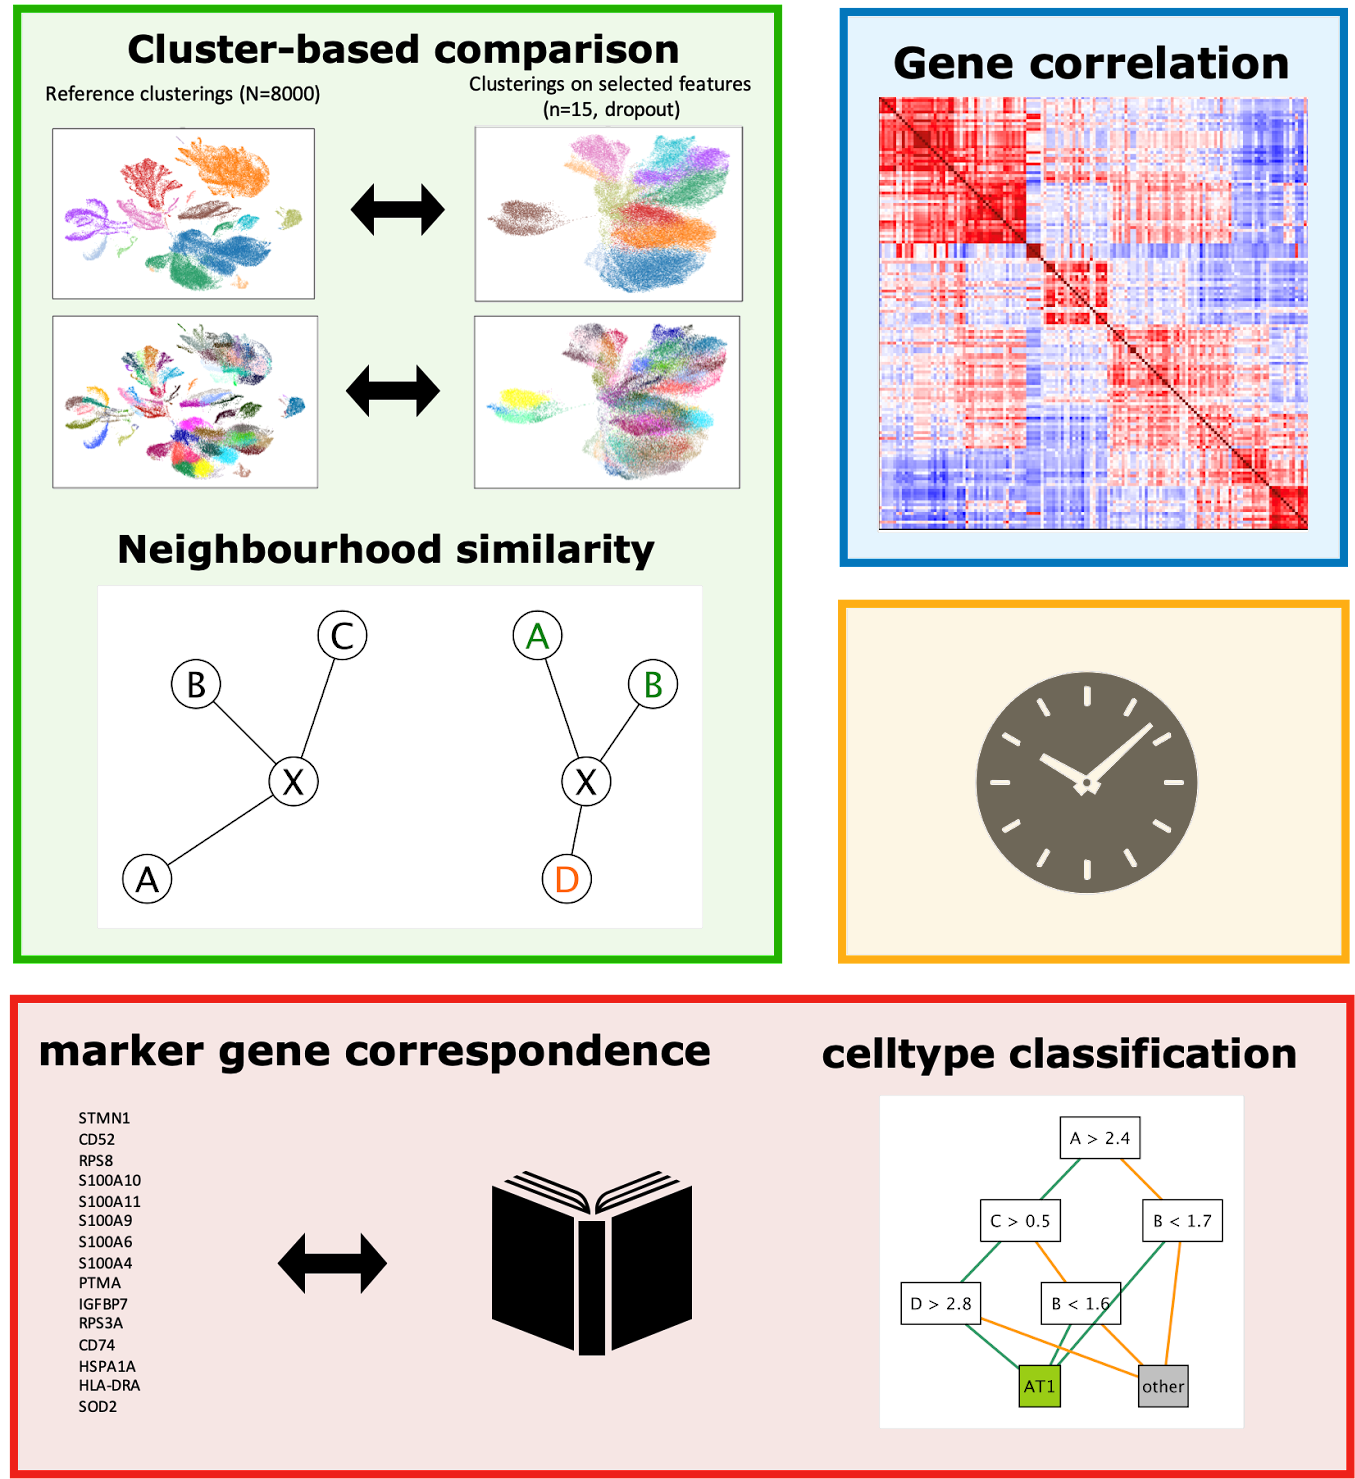

In [5]:
Image("../tutorials/abstract_figures/fig_01.png", width=300, height=300, embed=True)

In [6]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, n=50, celltype_key="celltype", verbosity=1, save_dir=None)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


In [7]:
# invoke the central method
selector.select_probeset()


Output()

The selected probeset can be examined like this:

In [8]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PPBP,1,True,1.0,1.0,1.0,1.000000,1.182710,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
LST1,2,True,1.0,1.0,1.0,0.749666,1.574997,False,False,True,FCGR3A+ Monocytes,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
HLA-DQA1,3,True,1.0,1.0,1.0,0.608147,1.034986,False,False,True,B cells,,B cells,B cells,False,True,False
GZMB,4,True,1.0,1.0,1.0,0.527486,1.317827,False,False,True,NK cells,,NK cells,NK cells,False,True,False
HLA-DRB1,5,True,1.0,1.0,1.0,0.432876,1.365428,False,False,True,Dendritic cells,,Dendritic cells,Dendritic cells,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-178G16.4,996,False,NaN,NaN,NaN,NaN,0.011824,False,False,False,,,,,False,False,False
RP11-324I22.4,997,False,NaN,NaN,NaN,NaN,0.011760,False,False,False,,,,,False,False,False
SYP,998,False,NaN,NaN,NaN,NaN,0.011548,False,False,False,,,,,False,False,False
RP11-252A24.3,999,False,NaN,NaN,NaN,NaN,0.010570,False,False,False,,,,,False,False,False


In [10]:
# list of the selected genes:
selector.probeset.index[selector.probeset.selection]

Index(['PPBP', 'LST1', 'HLA-DQA1', 'GZMB', 'HLA-DRB1', 'NKG7', 'S100A8',
       'IL32', 'CD79A', 'CCL5', 'HLA-DPB1', 'TYROBP', 'AIF1', 'LTB', 'GNLY',
       'FCER1A', 'LGALS2', 'FCN1', 'CST3', 'CST7', 'LINC00926', 'FGFBP2',
       'GZMK', 'LYAR', 'VAMP5', 'ATP5A1', 'MS4A6A', 'HLA-DQB1', 'TMEM50A',
       'HLA-DPA1', 'CD9', 'CD79B', 'GIMAP7', 'KLRG1', 'UBE2L6', 'IGLL5',
       'VAMP8', 'PDIA3', 'SDPR', 'PTCRA', 'CCL4', 'CD2', 'PRDX1', 'TCL1A',
       'PSME1', 'SMDT1', 'LIMD2', 'ACAP1', 'ODC1', 'UBE2D2'],
      dtype='object')

## Vizualize the results

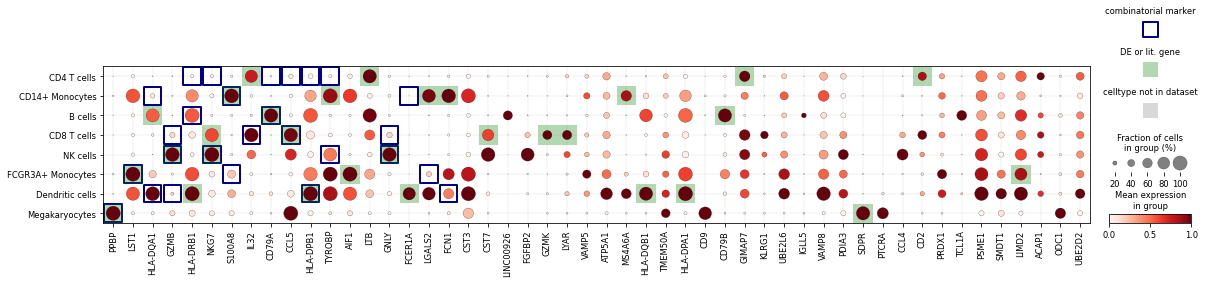

In [11]:
pl.masked_dotplot(adata, selector)

## What's next?

Now you should evaluate the selected probeset. See our [basic evaluation tutoral](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html).

If you want to customize and improve the probeset selection, have a look at the [advanced selection tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_selection.html).